In [15]:
import numpy as np
import os
import matplotlib.pyplot as plt
import scanpy as sc
from cv2 import resize
from tqdm.notebook import tqdm
import json

## A script to prepare the reference dataset further before axes transfer

In [16]:
xenium_path = 'D:/amonell/timecourse_final/day7_SI_DMSO'

#### You will need the villus segmentation from the aligned IF to run this

In [17]:
vill_seg = np.load(os.path.join(xenium_path, 'villi_segmentation_mask.npy'))

In [18]:
adata = sc.read(os.path.join(xenium_path, 'adatas', '06_before_decomposition_model.h5ad'))

In [19]:
file = open(os.path.join(xenium_path, 'xenium_output', 'experiment.xenium'))
pixel_size = json.load(file)['pixel_size']

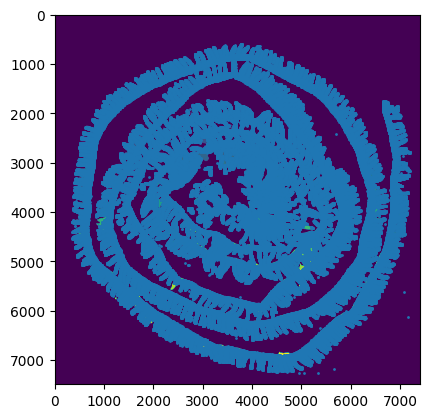

In [20]:
xvals = adata.obs.x.values
yvals = adata.obs.y.values

downsize_factor = np.load(os.path.join(xenium_path, 'villi_segmentation_downsize_factor.npy')) 

xvals = (xvals/downsize_factor)*(1/pixel_size)
yvals = (yvals/downsize_factor)*(1/pixel_size)

plt.imshow(vill_seg)
plt.scatter(xvals, yvals, s=1)
plt.show()

villi_numbers = vill_seg[yvals.astype(int), xvals.astype(int)]
adata.obs['villi_number'] = villi_numbers

### Defining the crypt-villi axis

In [21]:
in_villi = []
for i in adata.obs['villi_number'].values:
    if i == 0:
        in_villi.append(False)
    else:
        in_villi.append(True)

In [22]:
adata.obs['in_villi'] = in_villi
unique_villi = np.unique(adata.obs.villi_number)

In [23]:
norm_scaled = np.zeros(len(adata.obs.index.values))
for i in tqdm(unique_villi):
    if i == 0:
        indices = np.array(adata.obs['villi_number'] == i)
        norm_vals = adata[indices, :].obs['normalized_crypt_villi'].values
        norm_scaled[indices] = norm_vals
    else:
        indices = np.array(adata.obs['villi_number'] == i)
        norm_vals = adata[indices, :].obs['normalized_crypt_villi'].values
        norm_scaled[indices] = norm_vals/np.max(norm_vals)

  0%|          | 0/1449 [00:00<?, ?it/s]

C:\Users\amonell\anaconda3_2\envs\tensorflow\lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [24]:
adata.obs['normalized_crypt_villi_scaled'] = norm_scaled

C:\Users\amonell\anaconda3_2\envs\tensorflow\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


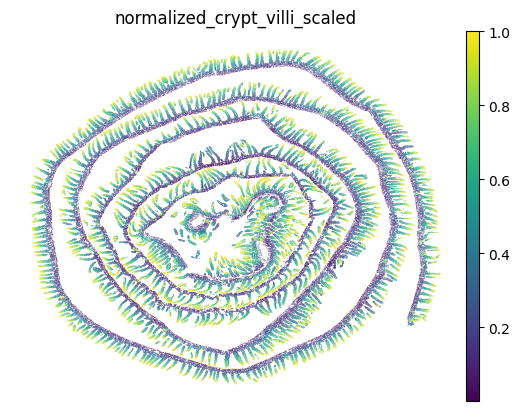

In [25]:
sc.pl.embedding(adata, basis='spatial', color='normalized_crypt_villi_scaled', frameon=False)

In [29]:
adata.write(os.path.join(xenium_path, 'adatas', '07_axes_defined_reference.h5ad'))